## Librerias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
from skimage import io
import tqdm
import pandas as pd
import tensorflow as tf


## Clases Seleccionadas

In [3]:
targets = ["maggie_simpson",
           "ned_flanders",
           "moe_szyslak",
           "krusty_the_clown",
           "principal_skinner",
           "charles_montgomery_burns",
           "gary_chalmers",
           "milhouse_van_houten",
           "chief_wiggum",
           "abraham_grampa_simpson"]
classes = dict()


In [4]:
for ind, value in enumerate(targets):
    paths = glob.glob(
        "C:/Users/migue/OneDrive/Escritorio/Tercer_Semestre/DATASETS/Springfield/**/{}/".format(value), recursive=True)
    Total_Files = []
    for i in paths:
        files = glob.glob("{}*.jpg".format(i))
        Total_Files += files
    print("{}:{} files".format(value, len(Total_Files)))
    classes[value] = {'path': paths,
                      'all_img_paths': Total_Files, 'label': ind}


maggie_simpson:1531 files
ned_flanders:1503 files
moe_szyslak:1502 files
krusty_the_clown:1256 files
principal_skinner:1245 files
charles_montgomery_burns:1241 files
gary_chalmers:1167 files
milhouse_van_houten:1140 files
chief_wiggum:1036 files
abraham_grampa_simpson:960 files


## Conjuntos de datos

In [5]:
row_table = []
for key, value in classes.items():
    train_val, test = train_test_split(value['all_img_paths'],
                                       test_size=0.1,
                                       random_state=1998)
    train, val = train_test_split(train_val,
                                  train_size=0.80,
                                  random_state=2022)
    classes[key]['train'] = train
    classes[key]['validation'] = val
    classes[key]['test'] = test

    row_table.append({'Name': key,
                      'Train Image': len(train),
                      'Validation Image': len(val),
                      'Test Image': len(test)})
df = pd.DataFrame(row_table)[['Name',
                              'Train Image',
                             'Validation Image',
                              'Test Image']].sort_values('Train Image', ascending=False).reset_index(drop=True)

df.loc["Total"] = df.sum(numeric_only=True, axis=0)
df.fillna('')


,Name,Train Image,Validation Image,Test Image
0,maggie_simpson,1101.0,276.0,154.0
1,ned_flanders,1081.0,271.0,151.0
2,moe_szyslak,1080.0,271.0,151.0
3,krusty_the_clown,904.0,226.0,126.0
4,principal_skinner,896.0,224.0,125.0
5,charles_montgomery_burns,892.0,224.0,125.0
6,gary_chalmers,840.0,210.0,117.0
7,milhouse_van_houten,820.0,206.0,114.0
8,chief_wiggum,745.0,187.0,104.0
9,abraham_grampa_simpson,691.0,173.0,96.0


## Codificación categorica

In [6]:
one_hot = tf.keras.utils.to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], num_classes=10)
one_hot_list = tf.constant(one_hot, shape=[10, 10]).numpy().astype(int).tolist()


In [7]:
one_hot_list

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

## Ejemplos de Preprocesamiento

In [8]:
from custom_defs import Preprocessing

In [13]:
%matplotlib inline

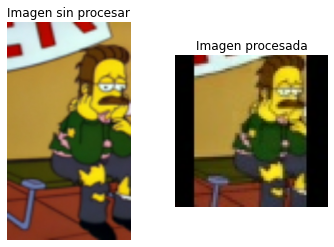

In [14]:
test_prepro=Preprocessing()
img=test_prepro.read_and_decode(classes['ned_flanders']['all_img_paths'][0])

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Imagen sin procesar")
plt.axis('off')

img=test_prepro.preprocess_image(img,to_bytes=True)
img = tf.image.decode_jpeg(img, channels=3)
plt.subplot(1,2,2)
plt.imshow(img)
plt.title("Imagen procesada")
plt.axis('off')
plt.show()

## Creación de archivos TFRecords

In [7]:
def _serialize_sample(image, label, label_cat):
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
        'label_cat': tf.train.Feature(int64_list=tf.train.Int64List(value=label_cat)),
    }
    sample = tf.train.Example(features=tf.train.Features(feature=feature))
    return sample.SerializeToString()


In [8]:
def create_files(set_name, Num_Files, path):

    i = 0
    for file in tqdm.tqdm(range(Num_Files)):
        data_len = []
        imgs_per_batch = []
        labels_per_batch = []
        for key, values in classes.items():
            imgs = values[set_name]
            label = values['label']
            N_Elements = len(imgs)//Num_Files
            start = i*N_Elements
            end = start+N_Elements

            files_selected = imgs[start:end]
            labels_selected = [label]*len(files_selected)

            imgs_per_batch.append(files_selected)
            labels_per_batch.append(labels_selected)

        imgs_per_batch = [j for i in imgs_per_batch for j in i]
        labels_per_batch = [j for i in labels_per_batch for j in i]
        data = np.stack((imgs_per_batch, labels_per_batch), axis=1)
        np.random.shuffle(data)
        serialize = Preprocessing()
        imgs = list(map(serialize.preprocess_image,
                        list(map(serialize.read_and_decode, data[:, 0]))))

        with tf.io.TFRecordWriter(path+set_name+"_"+str(file).zfill(2)+".tfrec") as writer:
            for img_one, label in list(zip(imgs, data[:, 1].astype(int))):
                writer.write(_serialize_sample(img_one, label,one_hot_list[label]))
            writer.close()
        i += 1


In [9]:
create_files(set_name='train', Num_Files=15, path='train/')
create_files(set_name='validation', Num_Files=15, path='validation/')
create_files(set_name='test', Num_Files=15, path='test/')


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


## Lectura de archivos TFRecords

In [14]:
feature_map = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_cat': tf.io.FixedLenFeature([10], tf.int64),
}


In [15]:
def read_tf_record(example):
    example = tf.io.parse_single_example(example, feature_map)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    label = example['label']
    cat_label=example['label_cat']
    return image, label,cat_label


def get_dataset(filename):
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map(read_tf_record)
    return dataset


In [16]:
batch1 = get_dataset('validation/validation_00.tfrec')
print(len(list(batch1.as_numpy_iterator())))

147


In [17]:
batch1 = get_dataset('train/train_00.tfrec')
print(len(list(batch1.as_numpy_iterator())))

600


In [11]:
plt.figure(figsize=(5,8))
plt.suptitle("Datos en train_00.tfrec")
for ind,val in enumerate(batch1.take(6)):
        plt.subplot(3,2,ind+1)
        plt.imshow(val[0])
        plt.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'batch1' is not defined

<Figure size 360x576 with 0 Axes>